## HW3: Generative Models

### Task 1.2 Beta-VAE

[Beta-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) encourages the model to learn disentangled representations by modifying the ELBO:

\begin{align*}
 \mathcal{L} &= \mathbb{E}_{q_{\phi}(\mathrm{z} \mid \mathrm{x})}[\log p_{\theta}(\mathrm{x} \mid \mathrm{z})] - \beta * KL\big(q_{\phi}(\mathrm{z} \mid \mathrm{x}) \parallel p(\mathrm{z})\big)
\end{align*}

A disentangled representation can be deﬁned as one where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors, [Bengio et al., 2013](https://arxiv.org/pdf/1206.5538.pdf).

As an example of visualized comparison on disentanglement learned by vanilla VAE and Beta-VAE shown below, it can be seen that Beta-VAE provides better disentanglement:

<img src="./imgs/disentangle.png" alt="Drawing" style="width: 800px;"/>

**To-dos**:

- Implement the class BetaVAE, You can reuse the modules you have defined in task 1.1.
- Implement the training and evaluation script, plot and save the loss/NLL curve.
- (20 points) Find the $\beta$ values by visual inspection that achieves the best disentanglement performance: it needs to be shown in your traversal plot that all of the generative factors ('shape', 'scale', 'posX', and 'posY') has their corresponding sensitive latent units through the traversal of the latent variable.

In [15]:
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.distributions import Normal, kl_divergence, Bernoulli
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
import os

In [16]:
class DspritesDataset(Dataset):
    def __init__(self, data_tensor):
        super(DspritesDataset, self).__init__()
        self.data = data_tensor
  
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
device = torch.device('cuda:0') # set it to torch.device('cpu') if you are using cpus
root = os.path.join('./dataset', 'dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
data = np.load(root, encoding='bytes')
imgs = torch.from_numpy(data['imgs']).unsqueeze(1).float()

# dsprites has 6 latent factors, controlling the color, shape, scale, rotation and position of the 
#     Color: white
#     Shape: square, ellipse, heart
#     Scale: 6 values linearly spaced in [0.5, 1]
#     Orientation: 40 values in [0, 2 pi]
#     Position X: 32 values in [0, 1]
#     Position Y: 32 values in [0, 1]
# object. We skip the factor 'rotation' to reduce the dataset size (only take rotation with 0 degrees). 
imgs = imgs.reshape(3, 6, 40, 32, 32, 1, 64, 64).permute(2, 0, 1, 3, 4, 5, 6, 7)[0]
imgs = imgs.reshape(-1, 1, 64, 64)

# randomly split the dataset into training set and test set
num_data = imgs.shape[0]
idx = np.arange(num_data)
np.random.shuffle(idx)
num_train = int(num_data * 0.8)
train_data = imgs[idx[:num_train]]
test_data = imgs[idx[num_train:]]

train_ds = DspritesDataset(train_data)
test_ds = DspritesDataset(test_data)


In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        """
        You design your own encoder network.

        An example from the Beta-VAE paper is provided below:
          Conv 32x4x4 (channel_out 32, kernel 4, stride 2, padding 1),
          Conv 32x4x4 (channel_out 32, kernel 4, stride 2, padding 1), 
          Conv 64x4x4 (channel_out 64, kernel 4, stride 2, padding 1),
          Conv 64x4x4 (channel_out 64, kernel 4, stride 2, padding 1),
          FC 256 (feature_dim_out 256).
          Non-linearity between layers: ReLU activation.
        """
        ###        Start of the code    ####
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)
        ###        End of the code    ####
    def forward(self, x, testing=True):
        """
        Inputs:
          x: 4D tensor, input images, (B, C, H, W)
          testing: boolean, if it's set to True, it means training phase
        Outputs:
          mu: 2D tensor, mean of the latent distribution
          std: 2D tensor, standard deviations of the latent distribution
        """
        ###        Start of the code    ####
#         x = x.reshape(-1, self.input_dim)
        # x is of shape [batch_size, input_dim]
        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]
        ###        End of the code    ####
        return mu, var

In [19]:
class Decoder(nn.Module):
    def __init__(self,  z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        """
        You design your own decoder network.

        An example provided from the Beta-VAE paper is to reverse
        the encoder defined above using ConvTranspose2d layers.
        """
        ###        Start of the code    ####
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim
        ###        End of the code    ####


    def forward(self, z):
        """
        Inputs:
          z: 2D tensor, latent variable, (B, z_dim)
        Output:
          rec_mu: 4D tensor, reconstructed images, (B, C, H, W)
        """
        ###        Start of the code    ####
        # x is of shape [batch_size, latent_dim]
        hidden = F.relu(self.linear(z))
        # hidden is of shape [batch_size, hidden_dim]
        rec_mu = torch.sigmoid(self.out(hidden))
        # rec_mu is of shape [batch_size, output_dim]
#         rec_mu = rec_mu.reshape(z.shape[0], -1, int(self.output_dim**(1/2)), int(self.output_dim**(1/2)))
        ###        End of the code    ####
        return rec_mu


In [27]:
class BetaVAE(nn.Module):
    def __init__(self, z_dim=20, beta=0.5, input_dim=64*64, hidden_dim=256):
        super(BetaVAE, self).__init__()
        #input_dim, hidden_dim, z_dim
        self.pic_wh = int(input_dim**0.5)
        self.enc = Encoder(input_dim, hidden_dim, z_dim)
        #z_dim, hidden_dim, output_dim
        self.dec = Decoder(z_dim, hidden_dim, input_dim)

    def forward(self, x, testing=False, k=50):
        """
        Inputs:
          x: 4D tensor, input images, (B, C, H, W)
          testing: boolean, if it's set to True, it means training phase
          k: number of samples
        Output:
          loss: scalar, averaged loss over this batch
          rec_mu: 4D tensor, reconstructed images, (B, C, H, W)
        """
        if testing:
            ###        Start of the code    ####      
            x = x.reshape(-1, self.pic_wh*self.pic_wh)
            x = x.repeat(k,1)
            
            z_mu, z_var = self.enc(x)
            eps = torch.randn_like(z_var)
            z_sample = eps.mul(z_var.mul(0.5).exp_()).add_(z_mu)
            x_sample = self.dec(z_sample)    
            
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
            kl_loss = beta * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            nll = recon_loss + kl_loss
            
#             log_p, log_q, log_p_given_z = self.the_distribtution(x_sample, x, z_sample, z_mu, z_var)
#             log_p = log_p.unsqueeze(-1).reshape(k, -1).transpose(0,1)
#             log_q = log_q.unsqueeze(-1).reshape(k, -1).transpose(0,1)
#             log_p_given_z = log_p_given_z.unsqueeze(-1).reshape(k, -1).transpose(0,1)
#             nll = self.comp_nll(log_p, log_q, log_p_given_z)
            
            ###        End of the code    ####
            return nll
        else:
            ###        Start of the code    ####
            # encode
            x = x.reshape(-1, self.pic_wh*self.pic_wh)
            x = x.repeat(k,1)

            z_mu, z_var = self.enc(x)
            eps = torch.randn_like(z_var)
            z_sample = eps.mul(z_var.mul(0.5).exp_()).add_(z_mu)
            x_sample = self.dec(z_sample)    
            
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
            kl_loss = beta * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            loss = recon_loss + kl_loss
            
            x_sample = x_sample.reshape(k,-1,self.pic_wh,self.pic_wh).mean(0).unsqueeze(1)
#             x_sample = x_sample.reshape(k, -1, self.pic_wh, self.pic_wh).transpose(0,1).mean(1).unsqueeze(1)
            ###        End of the code    ####

            return loss, x_sample
        
    def comp_nll(self, log_p, log_q, log_p_given_z):
        """
        Compute the NLL using importance sampling.
        Output:
        nll: 1D tensor, (B, ), negative marginal log-likelihood
        """
        ###        Start of the code    ####
        numOfSamples = log_p.shape[1]
        elbo = log_p + log_p_given_z - log_q
        log_p_x = - np.log(numOfSamples) + torch.logsumexp(elbo, dim=1)
        nll = -log_p_x.unsqueeze(-1)
        ###        End of the code    ####
        return  nll
    
    def elbo_loss(self, log_p, log_q, log_p_given_z):
        def log_mean_exp(x):
            max_, _ = torch.max(x, 1, keepdim=True)
            return torch.log(torch.mean(torch.exp(x - max_), 1)) + torch.squeeze(max_)
        elbo = (log_p + log_p_given_z - log_q)
        elbo = log_mean_exp(elbo)
        return -1*elbo.mean()    


    def the_distribtution(self, x_sample, x, z_sample, mu, log_var):
        def ll_gaussian(y, mu, log_var):
            return -0.5 * (
      log_var.sum(1) + ((y - mu).pow(2) / torch.exp(log_var)).sum(1))

        def ll_bernoulli(x_sample, x):
            loss = -F.relu(x_sample) + torch.mul(x, x_sample) -torch.log(1. + torch.exp(-x_sample.abs()))
            loss = loss.sum(-1)
            return loss
        log_p_given_z = ll_bernoulli(x_sample, x)
        log_p = ll_gaussian(z_sample, torch.zeros(mu.shape).cuda(), torch.zeros(mu.shape, dtype=torch.float).cuda())
        log_q = ll_gaussian(z_sample, mu, log_var)

        return log_p, log_q, log_p_given_z

A simple **train_model()** and a simple **eval_model()** helper function are provided as below. Feel free to modify them upon your needs.

In [21]:
def train_model(model, dataloader, optimizer, e):
    """
    Inputs:
    model: nn.Module, model to be trained
    dataloader: dataset iterator
    optimizer: optimizer
    e: current epoch, used to calculate the current iteration step
    """
    model.train()
    train_loss = 0.
    for i, img in enumerate(dataloader):
        step = e*len(dataloader) + i
        loss, rec = net(img.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach()

        if step % 500 == 0:    
            print('Steps:\t{}/{},\tloss:{:.6f}'.format(step, len(dataloader)*epochs, loss))
            rec_vis = vutils.make_grid(torch.cat([img[:4].cpu(), rec[:4].detach().cpu()], dim=0), nrow=4, pad_value=1)
            plt.imshow(rec_vis.permute(1,2,0))
            plt.show()

    train_loss = train_loss / float(len(dataloader))
    return model, train_loss

In [22]:
def eval_model(model, dataloader, k=1):
    """
    Inputs:
    model: nn.Module, model to be trained
    dataloader: iterator, dataset loader
    k: importance sampling sample numbers
    """
    nll = 0.
    model.eval()
    with torch.no_grad():
        for i, img in enumerate(dataloader):
            B, C, H, W = img.shape
            img = img.unsqueeze(1).expand(-1, k, -1, -1, -1).reshape(B*k, C, H, W)
            img = img.to(device)
            nll_batch = model(img, testing=True)
            nll += nll_batch.mean().detach()

    return nll

In [23]:
def traversal_plots(net, img, z_dim):
    torch.manual_seed(0)
    assert img.shape[0] == 1, "only support one image for traversal experiment"
    # infer the approximate posterior
    pic_wh = 64
    z_mu, z_var = net.enc(img.view(-1,pic_wh*pic_wh)) 
    z_std = z_var
    # sample from the approximate posterior
    eps = torch.randn_like(z_var)
    z = z_var.mul(0.5).exp_().add_(z_mu)
    std = z_var.mul(0.5).exp_()
    
    # traverse the latent space
    interpolation = torch.linspace(-3., 3., steps=10, device=img.device)
    rec_mus = []
    for dim in range(z_dim):
        for val in interpolation:
            ###   modify value of one latent unit
            y = z.clone()
            y[:, dim] = val        
            ### generate images with modified latentd
            x_sample = net.dec(y)
            x_sample = x_sample.reshape(pic_wh, pic_wh)
            img = x_sample.detach().to(torch.device('cpu'))
            rec_mus.append(img.view(64, 64))
    return rec_mus

10


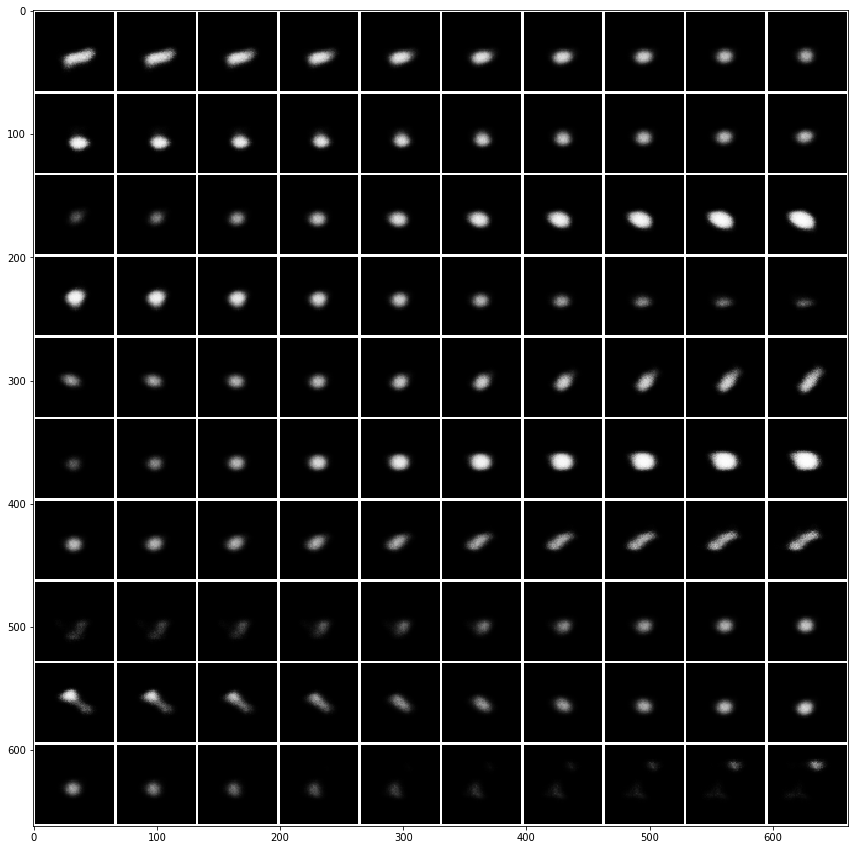

In [18]:
beta = 0.2
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())
#     print('Epoch:\t{}/{},\tnll:{:.6f}'.format(e, epochs, np.mean(nll.item())))
#     if (e+1) % 10 == 0:
#         plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
#         plt.show()
    
# plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
# plt.show()
# plt.savefig('./results/beta_vae_curves.png')    

idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta02_vae_traversal.png')

/home/lin/anaconda3/envs/p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


10


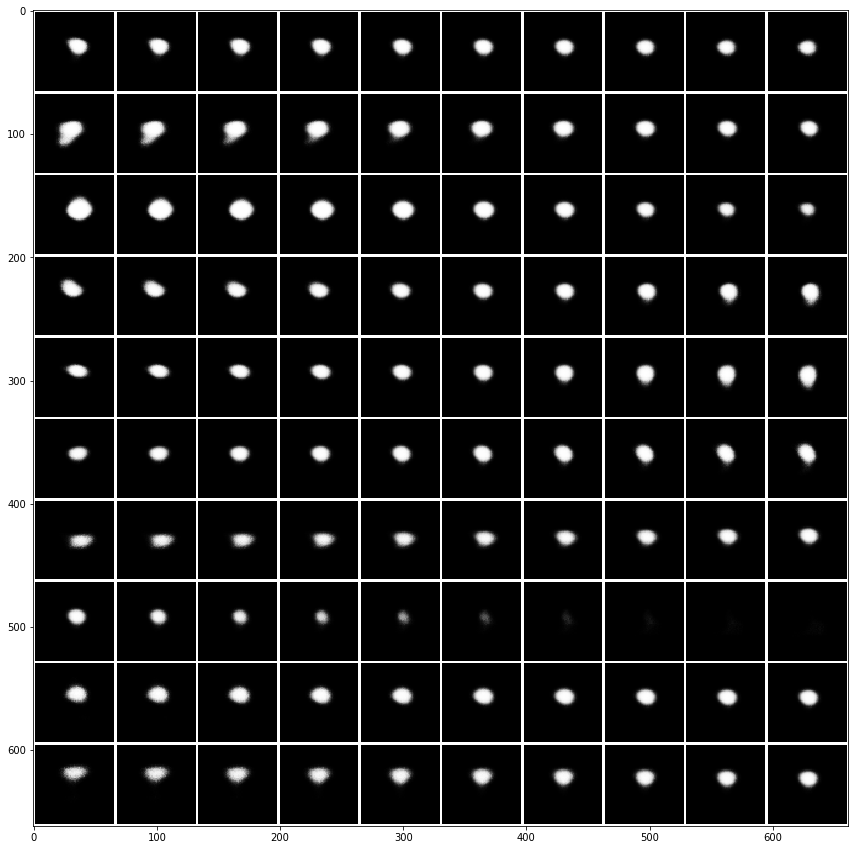

In [10]:
beta = 0.4
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())

idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta04_vae_traversal.png')

/home/lin/anaconda3/envs/p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


10


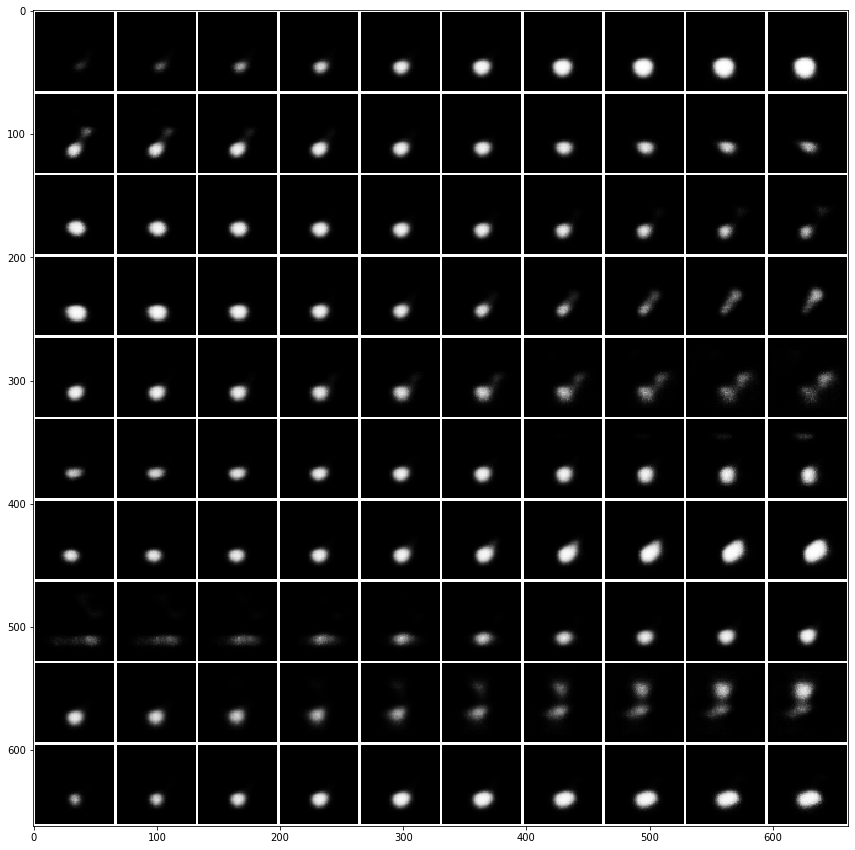

In [10]:
beta = 0.6
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())
    
    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())

idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta06_vae_traversal.png')

/home/lin/anaconda3/envs/p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


10


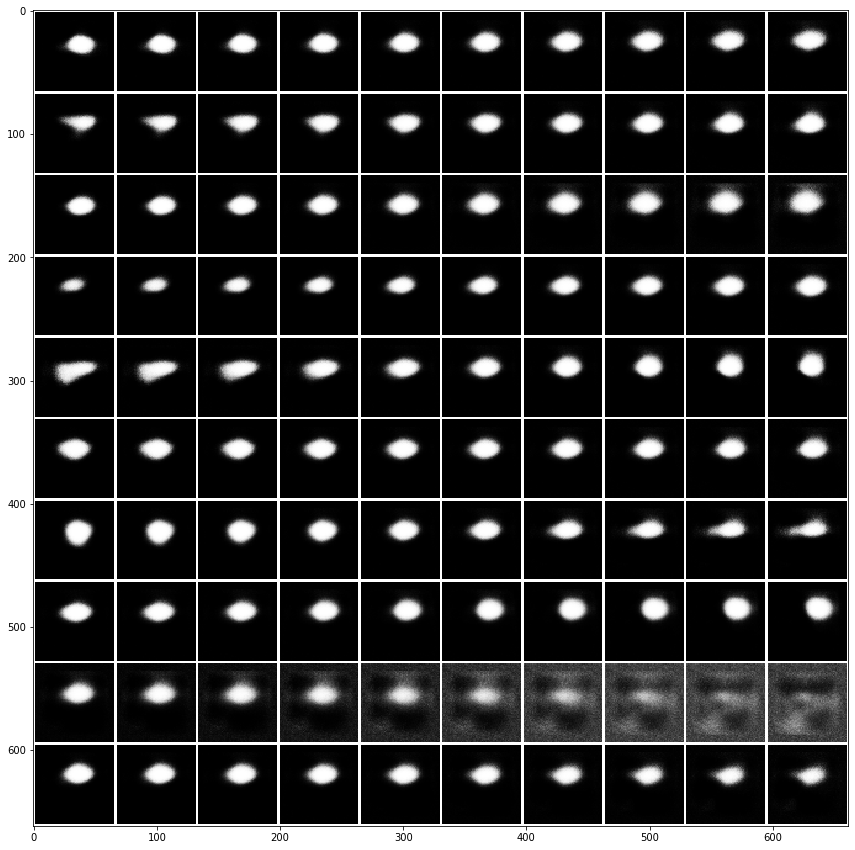

In [10]:
beta = 0.8
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())

idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta08_vae_traversal.png')

/home/lin/anaconda3/envs/p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


10


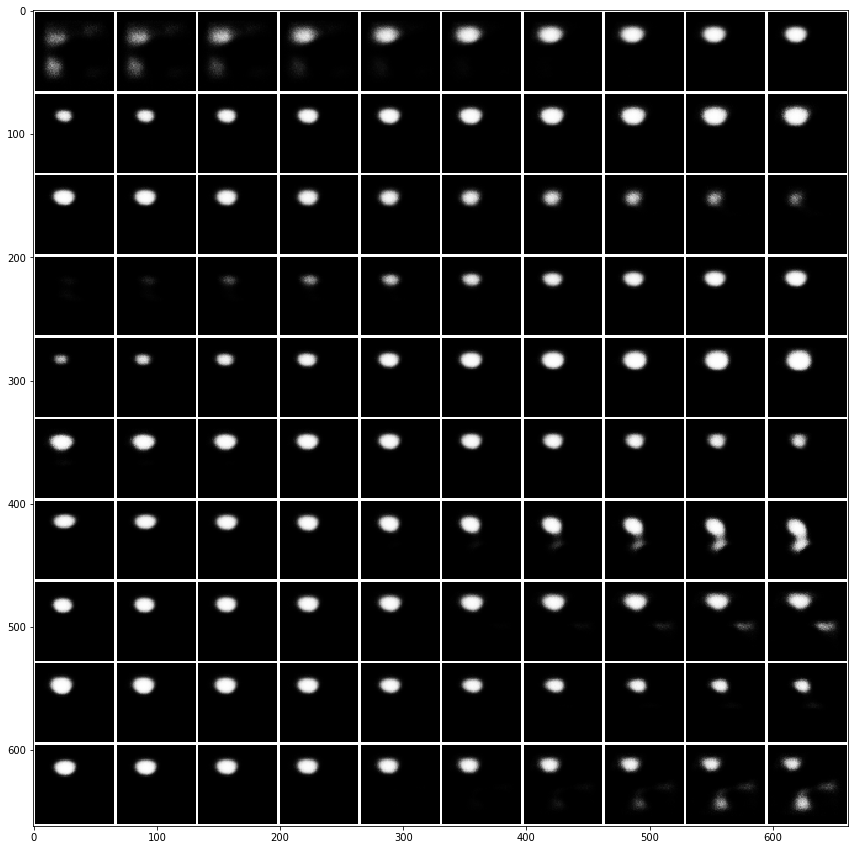

In [10]:
beta = 1.0
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())  

idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta10_vae_traversal.png')

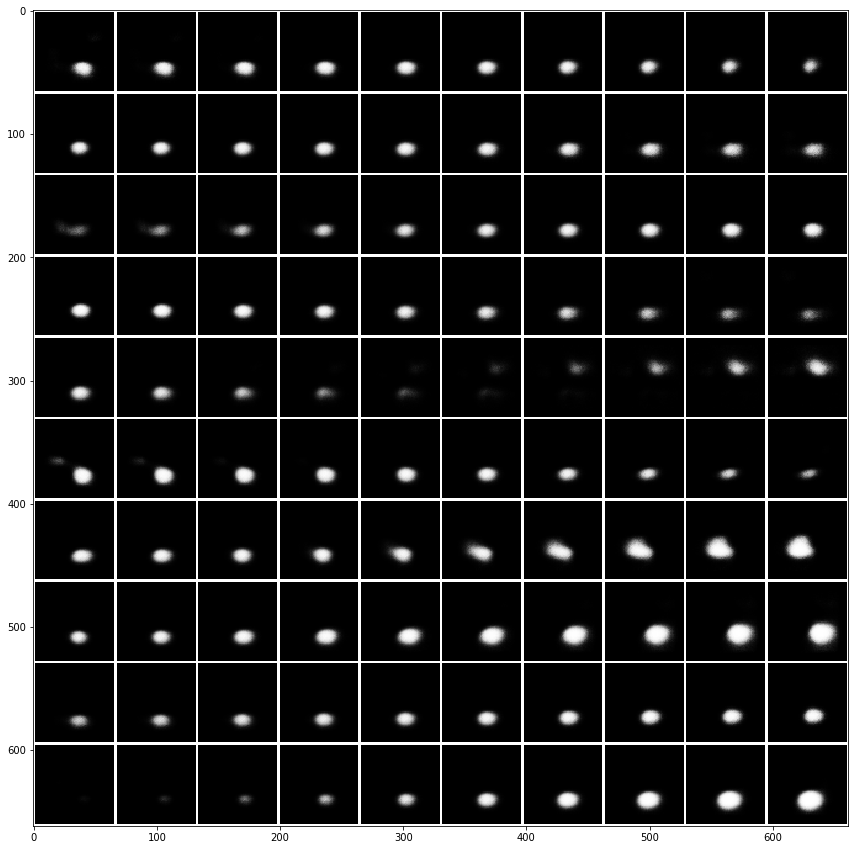

In [14]:
idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta10_vae_traversal.png')

The main training script is provided as follows. At the end of the training, the loss curve and NLL curve will be plotted and saved.

Feel free to modify it, and make sure your model has been trained till fully converged.

Generate and visualize images by sampling from the prior distribution:

Steps:	0/11500,	loss:9176576.000000


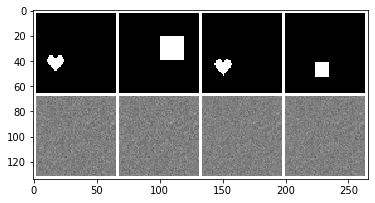

Epoch:	0/50,	nll:154017.625000
Epoch:	1/50,	nll:91220.757812
Steps:	500/11500,	loss:1278237.000000


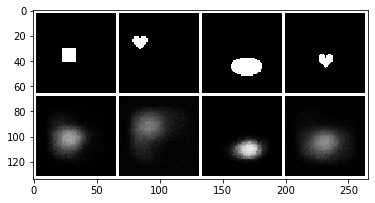

Epoch:	2/50,	nll:60927.292969
Epoch:	3/50,	nll:49435.777344
Steps:	1000/11500,	loss:756718.312500


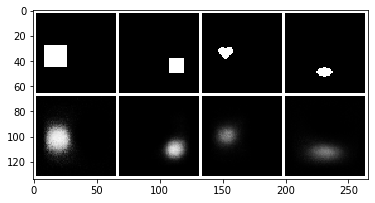

Epoch:	4/50,	nll:43444.347656
Epoch:	5/50,	nll:39448.382812
Steps:	1500/11500,	loss:629919.687500


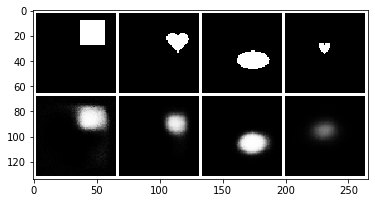

Epoch:	6/50,	nll:36533.292969
Epoch:	7/50,	nll:34294.546875
Steps:	2000/11500,	loss:531019.625000


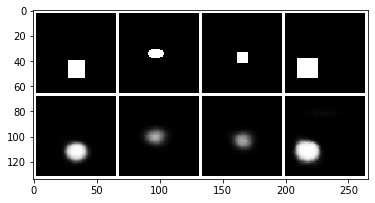

Epoch:	8/50,	nll:32496.011719
Epoch:	9/50,	nll:30970.322266


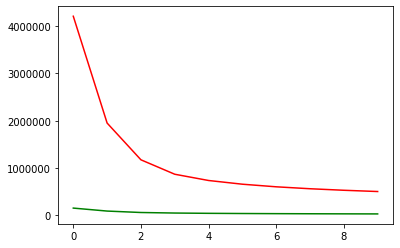

Steps:	2500/11500,	loss:496297.562500


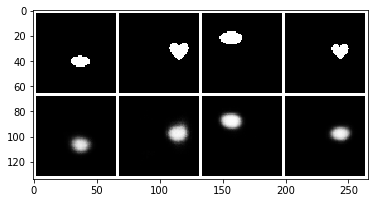

Epoch:	10/50,	nll:29682.599609
Epoch:	11/50,	nll:28517.033203
Epoch:	12/50,	nll:27489.402344
Steps:	3000/11500,	loss:425342.562500


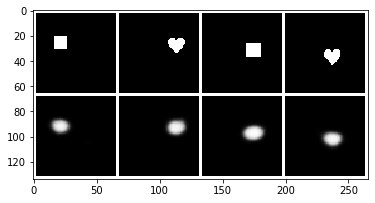

Epoch:	13/50,	nll:26550.492188
Epoch:	14/50,	nll:25690.042969
Steps:	3500/11500,	loss:404749.656250


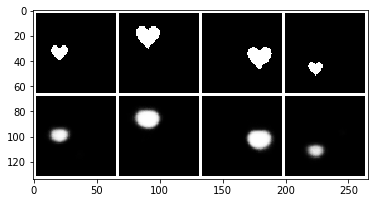

Epoch:	15/50,	nll:24919.277344
Epoch:	16/50,	nll:24213.746094
Steps:	4000/11500,	loss:377324.187500


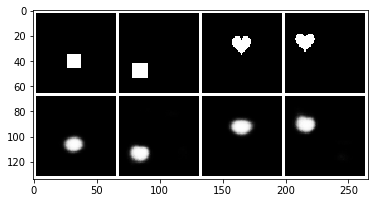

Epoch:	17/50,	nll:23546.943359
Epoch:	18/50,	nll:22943.845703
Steps:	4500/11500,	loss:366957.625000


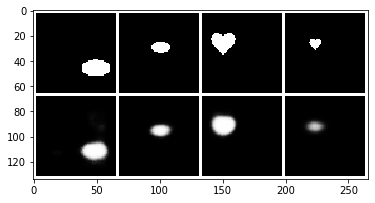

Epoch:	19/50,	nll:22393.396484


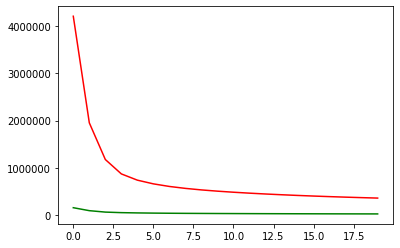

Epoch:	20/50,	nll:21867.181641
Steps:	5000/11500,	loss:341142.875000


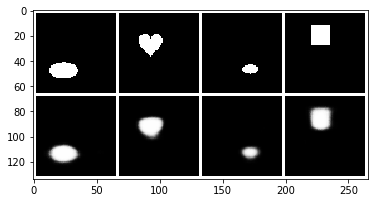

Epoch:	21/50,	nll:21379.550781
Epoch:	22/50,	nll:20949.064453
Steps:	5500/11500,	loss:330610.562500


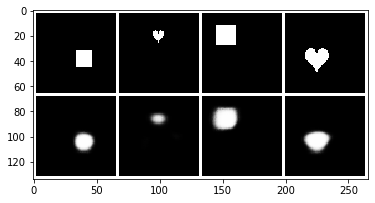

Epoch:	23/50,	nll:20539.382812
Epoch:	24/50,	nll:20179.179688
Epoch:	25/50,	nll:19829.849609
Steps:	6000/11500,	loss:313403.875000


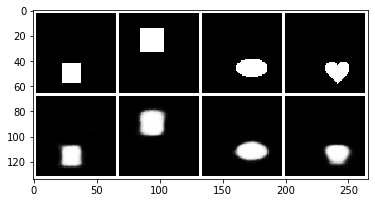

Epoch:	26/50,	nll:19514.503906
Epoch:	27/50,	nll:19202.406250
Steps:	6500/11500,	loss:302687.281250


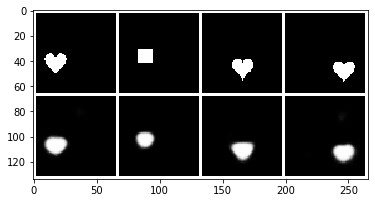

Epoch:	28/50,	nll:18928.259766
Epoch:	29/50,	nll:18682.484375


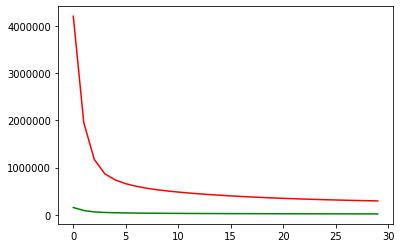

Steps:	7000/11500,	loss:302794.312500


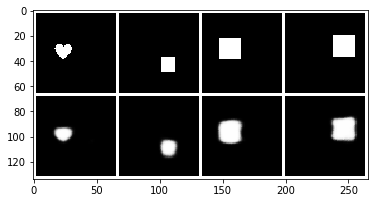

Epoch:	30/50,	nll:18430.285156
Epoch:	31/50,	nll:18224.787109
Steps:	7500/11500,	loss:283200.562500


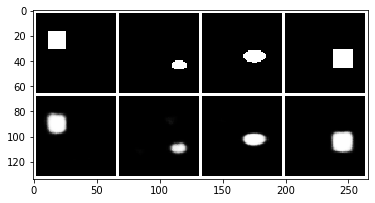

Epoch:	32/50,	nll:18008.919922
Epoch:	33/50,	nll:17801.296875
Steps:	8000/11500,	loss:268991.781250


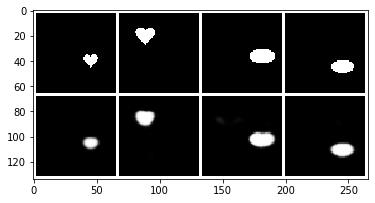

Epoch:	34/50,	nll:17617.019531
Epoch:	35/50,	nll:17456.238281
Steps:	8500/11500,	loss:275220.343750


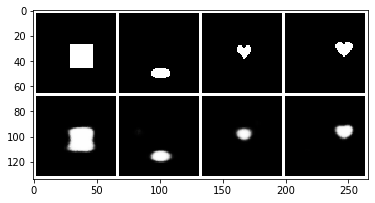

Epoch:	36/50,	nll:17291.726562
Epoch:	37/50,	nll:17122.185547
Epoch:	38/50,	nll:16987.794922
Steps:	9000/11500,	loss:254228.218750


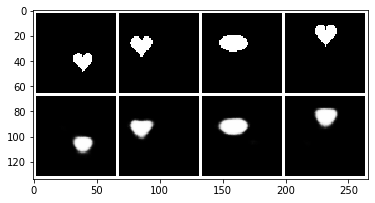

Epoch:	39/50,	nll:16836.947266


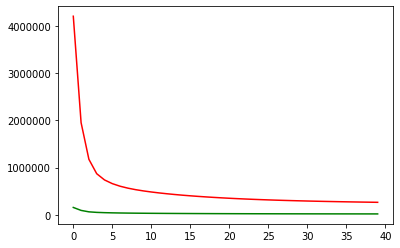

Epoch:	40/50,	nll:16714.080078
Steps:	9500/11500,	loss:265513.718750


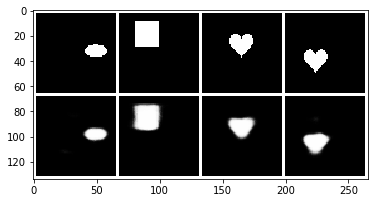

Epoch:	41/50,	nll:16596.763672
Epoch:	42/50,	nll:16478.560547
Steps:	10000/11500,	loss:258221.937500


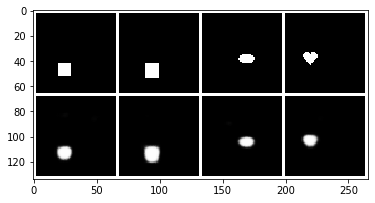

Epoch:	43/50,	nll:16382.229492
Epoch:	44/50,	nll:16253.855469
Steps:	10500/11500,	loss:235636.343750


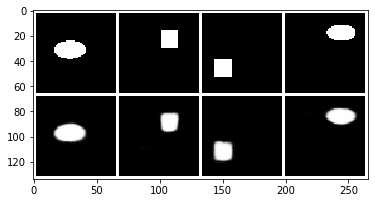

Epoch:	45/50,	nll:16170.894531
Epoch:	46/50,	nll:16060.573242
Steps:	11000/11500,	loss:246440.281250


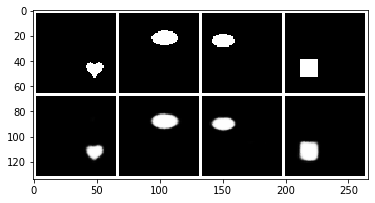

Epoch:	47/50,	nll:15972.828125
Epoch:	48/50,	nll:15886.758789
Epoch:	49/50,	nll:15791.954102


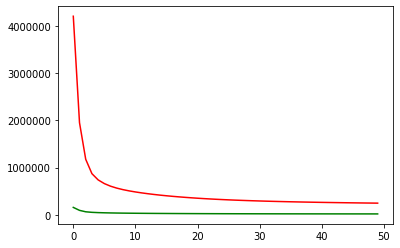

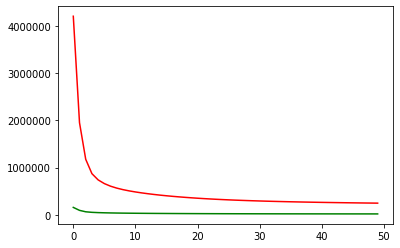

<Figure size 432x288 with 0 Axes>

In [28]:
# Relatively better Beta
beta = 0.6
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 50, 10, 64, 1e-4, torch.optim.Adam

dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = BetaVAE(z_dim, beta)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())
    print('Epoch:\t{}/{},\tnll:{:.6f}'.format(e, epochs, np.mean(nll.item())))
    if (e+1) % 10 == 0:
        plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
        plt.show()
    
plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
plt.show()
plt.savefig('./results/beta_vae_curves.png')    

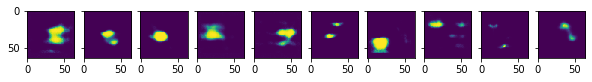

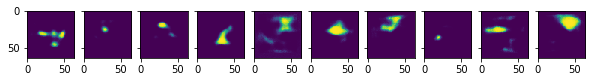

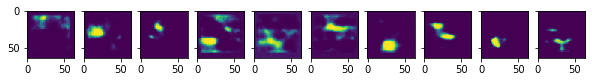

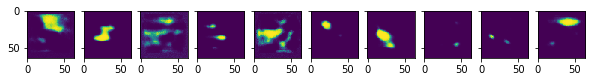

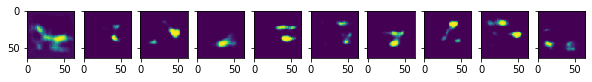

In [31]:
### please put your samples generating codes here ###
# Used Code from the following link
# https://sebastianraschka.com/deep-learning-resources.html
for i in range(5):
    
    n_images = 10
    rand_features = torch.randn(n_images, z_dim).to(device)
    new_images = net.dec(rand_features)

    image_width = 64

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]
    
    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)))
        
    plt.show()

To investigate the disentanglement property of the vanilla VAE, we visualize how the reconstruction changes along with the traversal of latent units.

This can be done by the following steps:
  - Sample the latent variable from the approximate posterior,
  - Change the value of one element by traversing over some range (three standard deviations around the unit Gaussian prior mean) while keeping the remaining latent units fixed,
  - Recover images from the modified latent variable.
  
The skeleton of the function **traversal_plots()** has been provided below, please complete it and plot traversal visualization of every single latent unit with vanilla VAE.

10


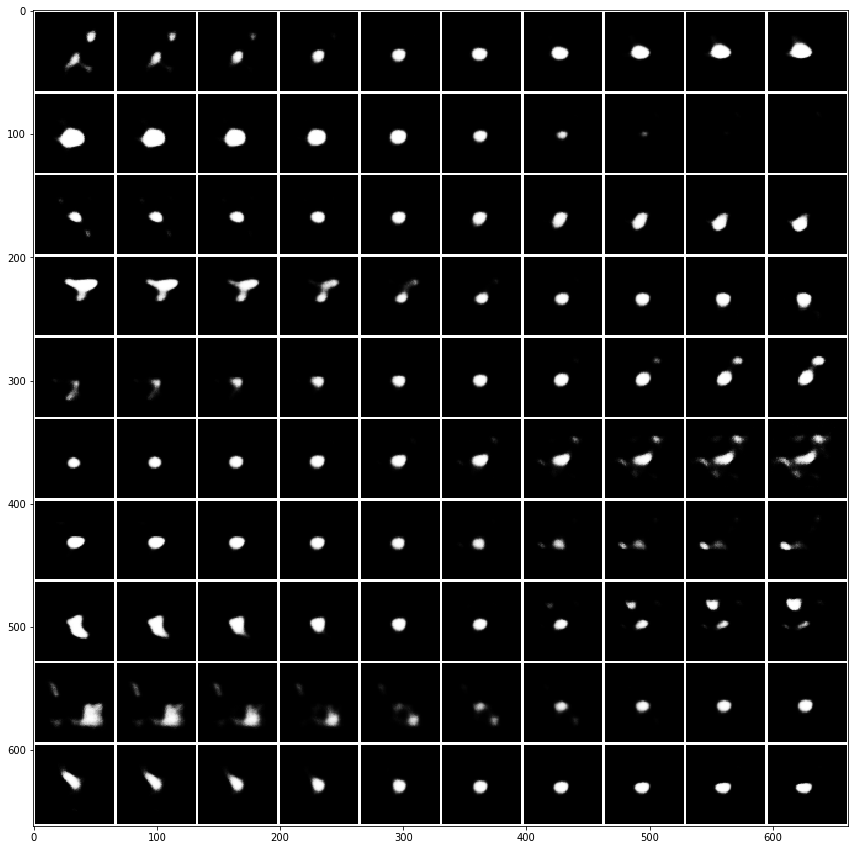

In [30]:
idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print(z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./beta_vae_traversal.png')